#### Background:

As a talent sourcing and management company, we are interested in finding talented individuals for sourcing these candidates to technology companies. Finding talented candidates is not easy, for several reasons. The first reason is one needs to understand what the role is very well to fill in that spot, this requires understanding the client’s needs and what they are looking for in a potential candidate. The second reason is one needs to understand what makes a candidate shine for the role we are in search for. Third, where to find talented individuals is another challenge.

The nature of our job requires a lot of human labor and is full of manual operations. Towards automating this process we want to build a better approach that could save us time and finally help us spot potential candidates that could fit the roles we are in search for. Moreover, going beyond that for a specific role we want to fill in we are interested in developing a machine learning powered pipeline that could spot talented individuals, and rank them based on their fitness.

We are right now semi-automatically sourcing a few candidates, therefore the sourcing part is not a concern at this time but we expect to first determine best matching candidates based on how fit these candidates are for a given role. We generally make these searches based on some keywords such as “full-stack software engineer”, “engineering manager” or “aspiring human resources” based on the role we are trying to fill in. These keywords might change, and you can expect that specific keywords will be provided to you.

Assuming that we were able to list and rank fitting candidates, we then employ a review procedure, as each candidate needs to be reviewed and then determined how good a fit they are through manual inspection. This procedure is done manually and at the end of this manual review, we might choose not the first fitting candidate in the list but maybe the 7th candidate in the list. If that happens, we are interested in being able to re-rank the previous list based on this information. This supervisory signal is going to be supplied by starring the 7th candidate in the list. Starring one candidate actually sets this candidate as an ideal candidate for the given role. Then, we expect the list to be re-ranked each time a candidate is starred.

#### Data Description:

The data comes from our sourcing efforts. We removed any field that could directly reveal personal details and gave a unique identifier for each candidate.

#### Attributes:
id : unique identifier for candidate (numeric)

job_title : job title for candidate (text)

location : geographical location for candidate (text)

connections: number of connections candidate has, 500+ means over 500 (text)

Output (desired target):
fit - how fit the candidate is for the role? (numeric, probability between 0-1)

Keywords: “Aspiring human resources” or “seeking human resources”

In [1]:

import pandas as pd
import io
import os
import nltk
import wordcloud

from nltk.corpus import stopwords
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import mammoth


from nltk.corpus import wordnet
from sklearn.decomposition import TruncatedSVD

In [2]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rames\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
df = pd.read_csv('potential-talents - Aspiring human resources - seeking human resources.csv')

In [4]:
df.head(100)

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN
...,...,...,...,...,...
95,96,Student at Indiana University Kokomo - Busines...,"Lafayette, Indiana",19,NaN
96,97,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,NaN
97,98,Student,"Houston, Texas Area",4,NaN
98,99,Seeking Human Resources Position,"Las Vegas, Nevada Area",48,NaN


In [5]:
def normalize_text(job_title):
    job_title = job_title.str.lower()
    job_title = job_title.str.replace(r"\#","")
    job_title = job_title.str.replace(r"http\S+","URL")
    job_title = job_title.str.replace(r"@","")
    job_title = job_title.str.replace(r"[^a-zA-Z0-9\' ']","")
    job_title = job_title.str.replace('HR','human resources')
    job_title = job_title.str.replace('\d+','')
    return job_title

In [6]:
df['job_title_cleaned'] = normalize_text(df['job_title'])
df['location_cleaned'] = normalize_text(df['location'])

In [7]:
df.head(100)

,id,job_title,location,connection,fit,job_title_cleaned,location_cleaned
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,ct bauer college of business graduate magna c...,houston texas
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN,native english teacher at epik english program...,kanada
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspiring human resources professional,raleighdurham north carolina area
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,people development coordinator at ryan,denton texas
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,advisory board member at celal bayar university,izmir trkiye
...,...,...,...,...,...,...,...
95,96,Student at Indiana University Kokomo - Busines...,"Lafayette, Indiana",19,NaN,student at indiana university kokomo business...,lafayette indiana
96,97,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,NaN,aspiring human resources professional,kokomo indiana area
97,98,Student,"Houston, Texas Area",4,NaN,student,houston texas area
98,99,Seeking Human Resources Position,"Las Vegas, Nevada Area",48,NaN,seeking human resources position,las vegas nevada area


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import re
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rames\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
# Remove stop words and lemmatize words in job_title_cleaned column and put the tokenized column on separate column 

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))

def tokenize_job_title(job_title):
    job_title = job_title.apply(lambda x:re.split('\s+',x))
    job_title = job_title.apply(lambda x:[item for item in x if item not in stop_words])
    lemmatizer = WordNetLemmatizer()
    job_title = job_title.apply(lambda x:[lemmatizer.lemmatize(item) for item in x])
    return job_title

df['job_title_lem'] = tokenize_job_title(df['job_title_cleaned'])
df['location_lem'] = tokenize_job_title(df['location_cleaned'])

In [10]:
df.head()

,id,job_title,location,connection,fit,job_title_cleaned,location_cleaned,job_title_lem,location_lem
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,ct bauer college of business graduate magna c...,houston texas,"[, ct, bauer, college, business, graduate, mag...","[houston, texas]"
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN,native english teacher at epik english program...,kanada,"[native, english, teacher, epik, english, prog...",[kanada]
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspiring human resources professional,raleighdurham north carolina area,"[aspiring, human, resource, professional]","[raleighdurham, north, carolina, area]"
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,people development coordinator at ryan,denton texas,"[people, development, coordinator, ryan]","[denton, texas]"
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,advisory board member at celal bayar university,izmir trkiye,"[advisory, board, member, celal, bayar, univer...","[izmir, trkiye]"


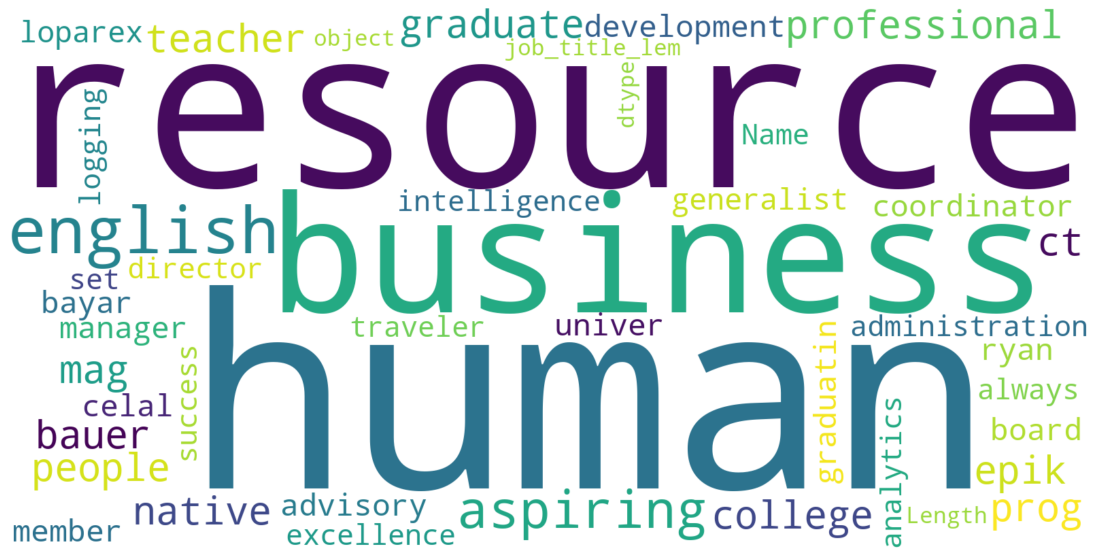

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(job_title):
    wordcloud = WordCloud(
    background_color = 'white',
    max_words=200,
    width=1600,
    height = 800,
    random_state=1
    ).generate(str(job_title))
    plt.figure(figsize = (30,10))
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.show()

plot_wordcloud(df['job_title_lem'])

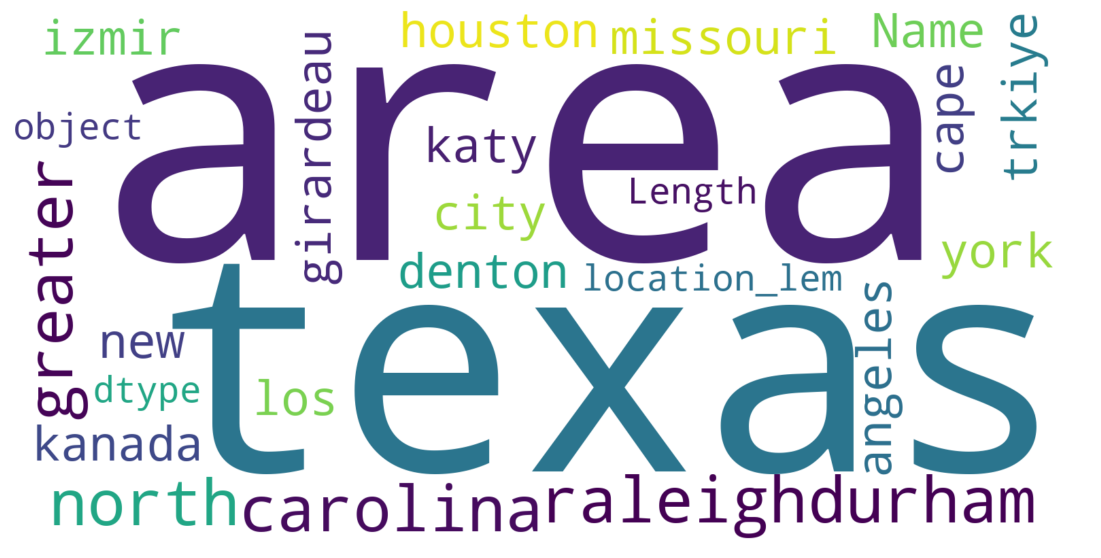

In [12]:
plot_wordcloud(df['location_lem'])

In [13]:
df = df[['id','job_title_lem','location_lem','fit']]
df.head()

,id,job_title_lem,location_lem,fit
0,1,"[, ct, bauer, college, business, graduate, mag...","[houston, texas]",NaN
1,2,"[native, english, teacher, epik, english, prog...",[kanada],NaN
2,3,"[aspiring, human, resource, professional]","[raleighdurham, north, carolina, area]",NaN
3,4,"[people, development, coordinator, ryan]","[denton, texas]",NaN
4,5,"[advisory, board, member, celal, bayar, univer...","[izmir, trkiye]",NaN


## TfidVectorizer on job_title_lem

In [14]:
# Join single word in job_title_lem column to form a single string

def joins_token(job_title):
    job_title = job_title.apply(lambda x: ' '.join(x))
    return job_title

df['job_title_lem'] = joins_token(df['job_title_lem'])
df['location_lem'] = joins_token(df['location_lem'])

In [15]:
df.head()

,id,job_title_lem,location_lem,fit
0,1,ct bauer college business graduate magna cum ...,houston texas,NaN
1,2,native english teacher epik english program korea,kanada,NaN
2,3,aspiring human resource professional,raleighdurham north carolina area,NaN
3,4,people development coordinator ryan,denton texas,NaN
4,5,advisory board member celal bayar university,izmir trkiye,NaN


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
vectorizer = TfidfVectorizer()
tf_idf_matrix = vectorizer.fit_transform(df['job_title_lem'])

In [17]:
print(vectorizer.get_feature_names_out())

['administration' 'administrative' 'admission' 'advisory' 'always'
 'america' 'analyst' 'analytics' 'army' 'art' 'aspiring' 'assistant'
 'atlanta' 'bachelor' 'bauer' 'bayar' 'beach' 'beneteau' 'biology' 'board'
 'brand' 'buckhead' 'business' 'care' 'celal' 'center' 'chapman' 'chro'
 'college' 'communication' 'community' 'compensation' 'coordinator'
 'create' 'csr' 'ct' 'cum' 'customer' 'data' 'delphi' 'development'
 'director' 'employment' 'endemol' 'energetic' 'energy' 'engaging' 'engie'
 'engineer' 'english' 'entrylevel' 'environment' 'environmental' 'epik'
 'excellence' 'executive' 'experienced' 'ey' 'generalist' 'gi' 'gphr'
 'graduate' 'graduating' 'groupe' 'guard' 'hardware' 'heil' 'helping'
 'houston' 'hr' 'hris' 'human' 'humber' 'illinois' 'inc' 'inclusive'
 'indiana' 'information' 'intelligence' 'intercontinental' 'international'
 'internship' 'japan' 'jti' 'junior' 'kokomo' 'korea' 'lab' 'laude' 'lead'
 'leader' 'liberal' 'logging' 'long' 'loparex' 'louis' 'love' 'luxottica'
 

In [18]:
tfidf_vector = tf_idf_matrix.toarray()
print(tfidf_vector.shape)

(104, 176)


In [20]:
# Search query and find the cosine similarity score

search_query = ['aspiring human resource']

search_vec = vectorizer.transform(search_query)

from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(tf_idf_matrix,search_vec)
fit_sim_score = [[similarity_matrix[i][0]] for i in range(len(similarity_matrix))]
df['fit'] = fit_sim_score
df.head()

,id,job_title_lem,location_lem,fit
0,1,ct bauer college business graduate magna cum ...,houston texas,[0.28479383109559947]
1,2,native english teacher epik english program korea,kanada,[0.0]
2,3,aspiring human resource professional,raleighdurham north carolina area,[0.7603042800238262]
3,4,people development coordinator ryan,denton texas,[0.0]
4,5,advisory board member celal bayar university,izmir trkiye,[0.0]


In [21]:
df.sort_values(by='fit',ascending = False).head(20)

,id,job_title_lem,location_lem,fit
16,17,aspiring human resource professional,raleighdurham north carolina area,[0.7603042800238262]
96,97,aspiring human resource professional,kokomo indiana area,[0.7603042800238262]
20,21,aspiring human resource professional,raleighdurham north carolina area,[0.7603042800238262]
57,58,aspiring human resource professional,raleighdurham north carolina area,[0.7603042800238262]
32,33,aspiring human resource professional,raleighdurham north carolina area,[0.7603042800238262]
45,46,aspiring human resource professional,raleighdurham north carolina area,[0.7603042800238262]
2,3,aspiring human resource professional,raleighdurham north carolina area,[0.7603042800238262]
59,60,aspiring human resource specialist,greater new york city area,[0.6966765440927953]
5,6,aspiring human resource specialist,greater new york city area,[0.6966765440927953]
23,24,aspiring human resource specialist,greater new york city area,[0.6966765440927953]


In [22]:
from sentence_transformers import SentenceTransformer
# random
import random
# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [23]:
# Build BERT_base model
bert_model = SentenceTransformer('bert-base-nli-mean-tokens')

## BERT

In [24]:
bert_job_title_embeddings = bert_model.encode(df['job_title_lem'])
bert_job_title_embeddings.shape

(104, 768)

In [25]:
bert_job_title_embeddings[0].shape

(768,)

In [26]:
keywords = pd.DataFrame({'keyword':['aspiring human resource']})

bert_search_phrase_embedding = bert_model.encode(keywords.keyword[0])
bert_search_phrase_embedding.shape

(768,)

In [27]:
# Calculate cosine similarity
bert_cosine_similarity = []
for i in range(len(df)):
    cos_sim = 1 - cosine(bert_job_title_embeddings[i],bert_search_phrase_embedding)
    bert_cosine_similarity.append(cos_sim)
    
df['bert_fit_score'] = bert_cosine_similarity

In [28]:
df.sort_values(by = 'bert_fit_score',ascending=False).head()

,id,job_title_lem,location_lem,fit,bert_fit_score
48,49,aspiring human resource specialist,greater new york city area,[0.6966765440927953],0.955137
5,6,aspiring human resource specialist,greater new york city area,[0.6966765440927953],0.955137
59,60,aspiring human resource specialist,greater new york city area,[0.6966765440927953],0.955137
23,24,aspiring human resource specialist,greater new york city area,[0.6966765440927953],0.955137
35,36,aspiring human resource specialist,greater new york city area,[0.6966765440927953],0.955137


### Choosing Random id for starring candidate

In [29]:
starred = [7,45,76]

In [30]:
starred

[7, 45, 76]

In [31]:
df['starred_score'] = df['bert_fit_score']
for id_num in starred:
    df.loc[df['id'] == id_num,'starred_score'] = 1
df.head()

,id,job_title_lem,location_lem,fit,bert_fit_score,starred_score
0,1,ct bauer college business graduate magna cum ...,houston texas,[0.28479383109559947],0.557126,0.557126
1,2,native english teacher epik english program korea,kanada,[0.0],0.384784,0.384784
2,3,aspiring human resource professional,raleighdurham north carolina area,[0.7603042800238262],0.948828,0.948828
3,4,people development coordinator ryan,denton texas,[0.0],0.746752,0.746752
4,5,advisory board member celal bayar university,izmir trkiye,[0.0],0.461810,0.461810


## Rank Using RankNet



In [32]:
class RankNet(nn.Module):
    
    def __init__(self, num_feature):
        super(RankNet, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(num_feature, 512),         
            nn.Dropout(0.5),                     
            nn.LeakyReLU(0.2, inplace=True),     
            nn.Linear(512, 256),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()                        
        )
        self.output_sig = nn.Sigmoid()

    def forward(self, input_1, input_2):
        s1 = self.model(input_1)
        s2 = self.model(input_2)
        out = self.output_sig(s1-s2)
        return out
    
    def predict(self, input_):
        s = self.model(input_)
        return s

In [33]:
random_row_1 = df.sample(n = 5000, replace = True)
random_row_2 = df.sample(n = 5000, replace = True)
job_title_list_ranknet1 = list(random_row_1['job_title_lem'])
job_title_list_ranknet2 = list(random_row_2['job_title_lem'])
doc1 = bert_model.encode(job_title_list_ranknet1)
doc2 = bert_model.encode(job_title_list_ranknet2)
doc1 = torch.from_numpy(doc1).float()
doc2 = torch.from_numpy(doc2).float()

In [34]:
y1 = list(random_row_1['starred_score'])
y2 = list(random_row_2['starred_score'])
y = torch.tensor([1.0 if y1_i>y2_i  else 0.5 if y1_i==y2_i else 0.0 for y1_i, y2_i in zip(y1, y2)]).float()

y = y.unsqueeze(1)

In [35]:
rank_model = RankNet(num_feature = 768)
optimizer = torch.optim.SGD(rank_model.parameters(), lr = 0.01, momentum = 0.9)       
loss_fun = torch.nn.BCELoss()             

In [36]:
epoch = 2000
losses = []

for i in range(epoch):
    rank_model.zero_grad()
    y_pred = rank_model(doc1, doc2)
    loss = loss_fun(y_pred,y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    if i % 100 == 0:
        print('Epoch{}, loss : {}'.format(i, loss.item()))

Epoch0, loss : 0.6903411149978638
Epoch100, loss : 0.5272188186645508
Epoch200, loss : 0.5133028030395508
Epoch300, loss : 0.510424017906189
Epoch400, loss : 0.5094435214996338
Epoch500, loss : 0.508112907409668
Epoch600, loss : 0.5084443092346191
Epoch700, loss : 0.5074709057807922
Epoch800, loss : 0.507825493812561
Epoch900, loss : 0.5074493885040283
Epoch1000, loss : 0.5067856311798096
Epoch1100, loss : 0.5072060823440552
Epoch1200, loss : 0.5073353052139282
Epoch1300, loss : 0.5072580575942993
Epoch1400, loss : 0.5064769387245178
Epoch1500, loss : 0.5065581202507019
Epoch1600, loss : 0.5070348978042603
Epoch1700, loss : 0.5067728757858276
Epoch1800, loss : 0.5074694156646729
Epoch1900, loss : 0.506084144115448


In [37]:
pred_score = []
for i in range(len(df)):
    embedding = bert_model.encode([df['job_title_lem'][i]])
    embedding_tensor = torch.from_numpy(embedding).float()
    pred = round(rank_model.predict(embedding_tensor).detach().numpy().sum(),2)
    pred_score.append(pred)

df['RankNet_score'] = pred_score
df.sort_values(by ='RankNet_score', ascending = False)

,id,job_title_lem,location_lem,fit,bert_fit_score,starred_score,RankNet_score
52,53,seeking human resource hris generalist position,greater philadelphia area,[0.22033477717279024],0.741072,0.741072,1.0
48,49,aspiring human resource specialist,greater new york city area,[0.6966765440927953],0.955137,0.955137,1.0
27,28,seeking human resource opportunity,chicago illinois,[0.2898434852935419],0.841447,0.841447,1.0
28,29,aspiring human resource management student see...,houston texas area,[0.3925889582429639],0.702358,0.702358,1.0
29,30,seeking human resource opportunity,chicago illinois,[0.2898434852935419],0.841447,0.841447,1.0
...,...,...,...,...,...,...,...
55,56,human resource coordinator intercontinental bu...,atlanta georgia,[0.19576318693728945],0.387098,0.387098,0.0
56,57,ct bauer college business graduate magna cum ...,houston texas,[0.28479383109559947],0.557126,0.557126,0.0
62,63,student chapman university,lake forest california,[0.0],0.426179,0.426179,0.0
63,64,svp chro marketing communication csr officer e...,houston texas area,[0.0],0.344135,0.344135,0.0


In [38]:
df

,id,job_title_lem,location_lem,fit,bert_fit_score,starred_score,RankNet_score
0,1,ct bauer college business graduate magna cum ...,houston texas,[0.28479383109559947],0.557126,0.557126,0.00
1,2,native english teacher epik english program korea,kanada,[0.0],0.384784,0.384784,0.01
2,3,aspiring human resource professional,raleighdurham north carolina area,[0.7603042800238262],0.948828,0.948828,1.00
3,4,people development coordinator ryan,denton texas,[0.0],0.746752,0.746752,1.00
4,5,advisory board member celal bayar university,izmir trkiye,[0.0],0.461810,0.461810,0.00
...,...,...,...,...,...,...,...
99,100,aspiring human resource manager graduating may...,cape girardeau missouri,[0.34064070792765383],0.593210,0.593210,0.04
100,101,human resource generalist loparex,raleighdurham north carolina area,[0.2548250714642568],0.630247,0.630247,0.60
101,102,business intelligence analytics traveler,greater new york city area,[0.0],0.475099,0.475099,0.00
102,103,always set success,greater los angeles area,[0.0],0.567987,0.567987,0.27
